In [1]:
import pandas as pd
from DataCreation.DataLoader import load_df
import pywt
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
import cv2
import scipy.signal as sig
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from scipy.stats import wasserstein_distance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
train = pd.read_parquet("DataCreation/train_alive_filtered.parquet")
test = pd.read_parquet("DataCreation/test_alive_filtered.parquet")
val = pd.read_parquet("DataCreation/val_alive_filtered.parquet")

In [4]:
train["RECG_N"] = train["RECG_N"].apply(lambda x: x[:512])
test["RECG_N"] = test["RECG_N"].apply(lambda x: x[:512])
val["RECG_N"] = val["RECG_N"].apply(lambda x: x[:512])

train["RSignalLen"] = train["RECG_N"].apply(lambda x: len(x))
test["RSignalLen"] = test["RECG_N"].apply(lambda x: len(x))
val["RSignalLen"] = val["RECG_N"].apply(lambda x: len(x))

In [5]:
maxlen = train["RSignalLen"].max()

train["padECG"] = train["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])
test["padECG"] = test["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])
val["padECG"] = val["RECG_N"].apply(lambda x: np.pad(x, [(0, maxlen  - len(x))])[:maxlen])

mean_ECG = np.mean(train["padECG"].values)
std_ECG = np.mean(test["padECG"].values)

In [6]:
maxlen

512

In [7]:
train["scaledECG"] = train["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)
test["scaledECG"] = test["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)
val["scaledECG"] = val["padECG"].apply(lambda x: (x - mean_ECG) / std_ECG)


train["welch"] = train["scaledECG"].apply(lambda x: welch(x)[1])
test["welch"] = test["scaledECG"].apply(lambda x: welch(x)[1])
val["welch"] = val["scaledECG"].apply(lambda x: welch(x)[1])

train["nwelch"] = train["welch"].apply(lambda x: x / np.sum(x))
test["nwelch"] = test["welch"].apply(lambda x: x / np.sum(x))
val["nwelch"] = val["welch"].apply(lambda x: x/ np.sum(x))

In [8]:
def create_scalogram(signal, level, filter_type):
    #n = int(maxlen/ (2 ** level)) + 1
    #print(n)
    signal = np.pad(signal, [(0, 2**level  - len(signal))])
    #print(len(signal))
    dwt = pywt.swt(signal, filter_type, level=level)
    #print(len(dwt[0][1]))
    m = np.concatenate([x[1] for x in dwt]).reshape(-1, len(signal))
    #print("new")
    #print(m.shape)
    s = np.sum(np.power(m, 2))
    m = np.power(m, 2) / (s * 1.0)
    #print(m.shape)
    return m


In [9]:
def new_create_scalogram(decrease_rate, signal, level, filter_type):
    #n = int(maxlen/ (2 ** level)) + 1
    #print(n)
    CA = signal
    for i in range(decrease_rate):
        CA, CD = pywt.dwt(CA, filter_type)
    signal = np.pad(CA, [(0, 2**level - len(CA))])
    #print(len(signal))
    dwt = pywt.swt(signal, filter_type, level=level)
    #print(len(dwt[0][1]))
    m = np.concatenate([x[1] for x in dwt]).reshape(-1, len(signal))
    
    #print(m.shape)
    s = np.sum(np.power(m, 2))
    m = np.power(m, 2) / (s * 1.0)
    #print(m.shape)
    return m

In [10]:
from tqdm import tqdm
import multiprocess as mp

In [11]:
def get_distance_matrix(train, test, distance):
    dist_matrix = np.zeros((test.shape[0], train.shape[0]))
    for i in tqdm(range(test.shape[0])):
        for j in range(train.shape[0]):
            dist_matrix[i,j] = distance(test[i] , train[j])
    return dist_matrix

In [12]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

/Users/valeria.guryanova/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
def emd_preparation(maxlen, df_train, df_test, df_val, 
                    levels, filter_type, l1, l2, 
                    p_train, p_test, p_val,
                    write=False, rs="full", ):
    names = []
    df_train = df_train.copy()
    df_test = df_test.copy()
    df_val = df_val.copy()
    df_train["scalogram"] = df_train["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[l1:l2])
    df_test["scalogram"] = df_test["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[l1:l2])
    df_val["scalogram"] = df_val["scaledECG"].progress_apply(lambda x: create_scalogram(x, levels, filter_type)[l1:l2])
    matrix_shape = df_train["scalogram"][100].shape
    print(matrix_shape)
    df_train["scalogram"] = df_train["scalogram"].apply(lambda x: x.reshape(-1))
    df_test["scalogram"] = df_test["scalogram"].apply(lambda x: x.reshape(-1))
    df_val["scalogram"] = df_val["scalogram"].apply(lambda x: x.reshape(-1))
    if write:
        name =  str(maxlen) +"_" + filter_type + "_" + str(levels) + "_"  + str(l1) + "_" +str(l2) + "_"+ str(rs) 
        name += "_" + str(matrix_shape[0]) + "_" + str(matrix_shape[1]) + "_" + str(p_train)
               
        name_train = "train" + "_" + name 
        name_test = "test" + "_" + name
        name_val = "val" + "_" + name
        if rs != "full":
            name_test += "_" + str(p_test)
            name_val += "_" + str(p_val)
        print(name_train)
        print(name_test)
        print(name_val)
        names.append(name_train)
        names.append(name_val)
        names.append(name_test)
        df_train.to_parquet("DistanceData/" + name_train + ".p")
        df_test.to_parquet("DistanceData/" + name_test + ".p")
        df_val.to_parquet("DistanceData/" + name_val +".p")
    return df_train, df_test, df_val, names
            

In [90]:
def get_quallity(df, prediction, print_by_cat=False):
    df = df.copy()
    df["pred"] = prediction
    #df = df[df["target"]!="~"].copy()
    
    a = accuracy_score(df["target"], df["pred"])
    if print_by_cat:
        df["indicator"] = df["pred"] == df["target"]
        print(df.groupby("target").indicator.mean())
    f1 = f1_score(df["target"], df["pred"], average='weighted')
    #print(f1)
    b_a = balanced_accuracy_score(df["target"], df["pred"])
    #print(b_a)
    return a, f1, b_a

def get_quality_on_classifier(k, test_train_mat, train_df, test_df, print_by_cat=False,
                              weights='uniform'):
    distance_matrix_train =  np.random.rand(train_df.shape[0], train_df.shape[0])
    neigh = KNeighborsClassifier(n_neighbors=k, metric="precomputed", weights=weights)
    neigh.fit(np.array(distance_matrix_train), train_df["target"])
    prediction = neigh.predict(test_train_mat)
    a, f1, b_a = get_quallity(test_df, prediction, print_by_cat)
    return a, f1, b_a

def evaluate(max_k, df_train, df_test, df_val, test_distances, 
                val_distances, weights, return_vals=True):
    accs = []
    f1s = []
    b_as = []
    for i in range(1, max_k + 1):
        a, f1, b_a = get_quality_on_classifier(i, val_distances,
                             df_train, df_val, weights=weights)
        accs.append(a)
        f1s.append(f1)
        b_as.append(b_a)
    print("****accuracy****")
    k_acc = np.argmax(accs)+1
    get_quality_on_classifier(k_acc, val_distances, df_train, df_val, False, weights=weights)
    k_f = np.argmax(f1s)+1
    get_quality_on_classifier(k_f, val_distances, df_train, df_val, False, weights=weights)
    f1_val = max(f1s)
    a_main, f1, b_a = get_quality_on_classifier(k_acc, test_distances,
                                           df_train, df_test, True, weights=weights)
    print(a_main, " k = ", k_acc)
    print("****f1_score****")
    a, f1_main, b_a = get_quality_on_classifier(k_f, test_distances,
                             df_train, df_test, True, weights=weights)
    print(f1_main, " k = ", k_f)
    if return_vals:
        return f1_val, f1_main

In [15]:
random_state = 11
train_size = 0.15
test_size = 0.3
val_size = 0.3
levels = 9
filter_type = "bior6.8"
l1  = 0
l2 = 7
decrease_rate = 2

sample_train = train_test_split(train, test_size=train_size, stratify = train.target.values,
                                random_state=random_state)[1].reset_index(drop=True)
sample_test = train_test_split(test, test_size=test_size, stratify = test.target.values,
                               random_state=random_state)[1].reset_index(drop=True)
sample_val = train_test_split(val, test_size=val_size, stratify = val.target.values,
                               random_state=random_state)[1].reset_index(drop=True)


df_train, df_test, df_val, names = emd_preparation(maxlen, sample_train, sample_test, sample_val, 
                                            levels, filter_type, l1, l2, 
                                            train_size, test_size, val_size,
                                            write=True, rs=random_state)



100%|██████████| 630/630 [00:02<00:00, 240.32it/s]


(7, 512)
train_512_bior6.8_9_0_7_11_7_512_0.15
test_512_bior6.8_9_0_7_11_7_512_0.15_0.3
val_512_bior6.8_9_0_7_11_7_512_0.15_0.3


In [83]:
names[2]

'test_512_bior6.8_9_0_8_11_8_512_0.15_0.3'

In [93]:
def get_best_alpha_and_plot(df_train, df_val, df_test, name_val, name_test):
    alpha_values = [1.4, 1, 0.8, 0.5, 0.3, 0.2, 0.1, 0.07, 0.03, 0.001]
    f_vals = []
    f_tests = []
    for i in alpha_values:
        test_distances = pd.read_csv("DistanceData/" + name_test+"_" + str(i) +  "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1)
        val_distances = pd.read_csv("DistanceData/" + name_val+"_" + str(i) +  "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1)
        f_val, f_test =  evaluate(50, df_train, df_test, df_val, test_distances, val_distances, weights="distance")
        f_vals.append(f_val)
        f_tests.append(f_test)
    best_ind = np.argmax(f_vals)
    best_alpha = alpha_values[best_ind]
    final_f = f_tests[best_ind]
    
    return best_alpha, final_f, alpha_values, f_tests
    
    

7 уровней

In [116]:
name_test = 'test_512_bior6.8_9_0_7_11_7_512_0.15_0.3'
name_val = 'val_512_bior6.8_9_0_7_11_7_512_0.15_0.3'

In [117]:
best_alpha, final_f, alpha_values, f_tests = get_best_alpha_and_plot(df_train, df_val, df_test, name_val, name_test)

****accuracy****
target
A    0.000000
N    0.991848
O    0.025907
~    0.000000
Name: indicator, dtype: float64
0.598705501618123  k =  44
****f1_score****
target
A    0.018519
N    0.861413
O    0.155440
~    0.000000
Name: indicator, dtype: float64
0.4933742427550479  k =  8
****accuracy****
target
A    0.000000
N    0.989130
O    0.025907
~    0.000000
Name: indicator, dtype: float64
0.5970873786407767  k =  44
****f1_score****
target
A    0.074074
N    0.788043
O    0.248705
~    0.000000
Name: indicator, dtype: float64
0.5132247796471703  k =  4
****accuracy****
target
A    0.000000
N    0.989130
O    0.015544
~    0.000000
Name: indicator, dtype: float64
0.5938511326860841  k =  47
****f1_score****
target
A    0.074074
N    0.777174
O    0.243523
~    0.000000
Name: indicator, dtype: float64
0.5062732295162724  k =  4
****accuracy****
target
A    0.000000
N    0.991848
O    0.015544
~    0.000000
Name: indicator, dtype: float64
0.5954692556634305  k =  49
****f1_score****
target


In [118]:
print(best_alpha)
print(final_f)

0.07
0.5235360791104943


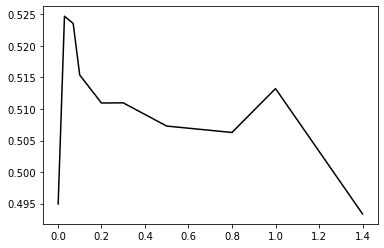

In [119]:
plt.plot(alpha_values, f_tests, color="black")
plt.savefig('ResultImages/alive_7_levels_alpha.png')

In [120]:
test_distances_emd = pd.read_csv("DistanceData/" + name_test+"_" + str(0.07) +  "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1)
val_distances_emd = pd.read_csv("DistanceData/" + name_val+"_" + str(0.07) +  "_dist.csv", index_col=False).drop("Unnamed: 0", axis=1)

## Оценить Фурье

In [87]:
def get_distance_matrix(train, test, distance):
    dist_matrix = np.zeros((test.shape[0], train.shape[0]))
    for i in tqdm(range(test.shape[0])):
        for j in range(train.shape[0]):
            dist_matrix[i,j] = distance(test[i] , train[j])
    return dist_matrix


distance_matrix_furie_test = get_distance_matrix(df_train["nwelch"],  df_test['nwelch'], wasserstein_distance)
distance_matrix_furie_val = get_distance_matrix(df_train["nwelch"],  df_val['nwelch'], wasserstein_distance)

100%|██████████| 630/630 [00:27<00:00, 23.19it/s]


In [92]:
evaluate(50, df_train, df_test, df_val, distance_matrix_furie_test, distance_matrix_furie_val, weights="distance", return_vals=False)

****accuracy****
target
A    0.000000
N    0.945652
O    0.072539
~    0.000000
Name: indicator, dtype: float64
0.5857605177993528  k =  46
****f1_score****
target
A    0.037037
N    0.864130
O    0.124352
~    0.000000
Name: indicator, dtype: float64
0.4843480896854334  k =  18


O


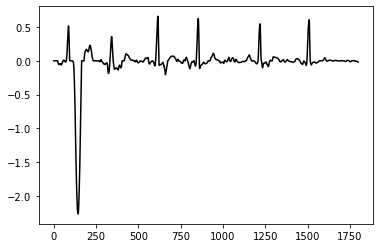

In [148]:
ind_test = 3
s_b = 0
s_len = 1800
distances = test_distances_emd.values
ind_train_emd = np.argmin(distances[ind_test])
ind_train_furie = np.argmin(distance_matrix_furie_test[ind_test])
plt.plot(range(s_b, s_len), df_test["ECG_F"][ind_test][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_3_orig.png')
print(df_test.target.values[ind_test])

N


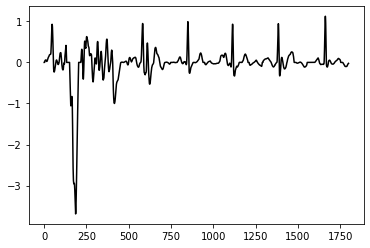

In [149]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_emd][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_3_emd.png')
print(df_train.target.values[ind_train_emd])

A


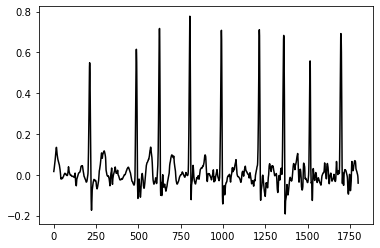

In [150]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_furie][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_3_furie.png')
print(df_train.target.values[ind_train_furie])

O


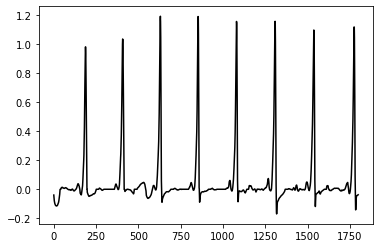

In [163]:
ind_test = 88
s_b = 0
s_len = 1800
distances = test_distances_emd.values
ind_train_emd = np.argmin(distances[ind_test])
ind_train_furie = np.argmin(distance_matrix_furie_test[ind_test])
plt.plot(range(s_b, s_len), df_test["ECG_F"][ind_test][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_88_orig.png')
print(df_test.target.values[ind_test])

O


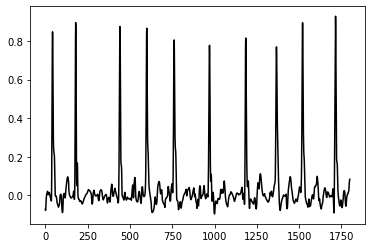

In [164]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_emd][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_88_emd.png')
print(df_train.target.values[ind_train_emd])

N


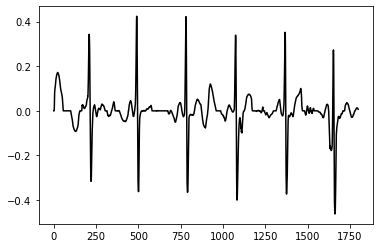

In [165]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_furie][s_b:s_len], color="black")
plt.savefig('ResultImages/alive_88_furie.png')
print(df_train.target.values[ind_train_furie])

O


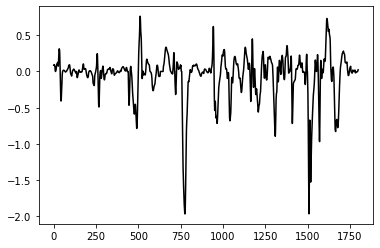

In [175]:
ind_test = 120
s_b = 0
s_len = 1800
distances = test_distances_emd.values
ind_train_emd = np.argmax(distances[ind_test])
ind_train_furie = np.argmax(distance_matrix_furie_test[ind_test])
plt.plot(range(s_b, s_len), df_test["ECG_F"][ind_test][s_b:s_len], color="black")
#plt.savefig('ResultImages/alive_88_orig.png')
print(df_test.target.values[ind_test])

A


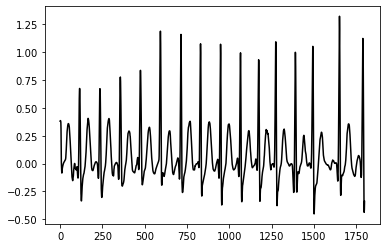

In [176]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_emd][s_b:s_len], color="black")
#plt.savefig('ResultImages/alive_88_emd.png')
print(df_train.target.values[ind_train_emd])

O


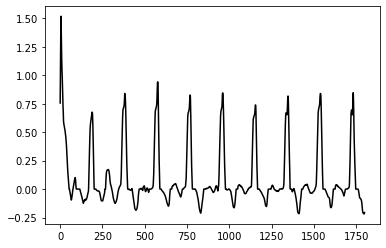

In [177]:
plt.plot(range(s_b, s_len), df_train["ECG_F"][ind_train_furie][s_b:s_len], color="black")
#plt.savefig('ResultImages/alive_88_furie.png')
print(df_train.target.values[ind_train_furie])

In [170]:
sorted(test_distances_emd.values[0])

[1.2329706074106102,
 2.0397848855842398,
 2.16060254875039,
 2.16221164872728,
 2.19215947847892,
 2.26313043126531,
 2.3086644939866803,
 2.37743946355243,
 2.46496668281734,
 2.47192463857367,
 2.51164158690914,
 2.513607612981,
 2.5980680837865298,
 2.66089629501527,
 2.6883965936162104,
 2.7119751839199,
 2.75553948827625,
 2.75704981982072,
 2.7775150220478304,
 2.7914378420766495,
 2.79339631459726,
 2.80921853133633,
 2.8163202178365805,
 2.8180248162361403,
 2.82343327562568,
 2.82493406871884,
 2.8413724953713198,
 2.85239366011043,
 2.85443243675431,
 2.85588866762338,
 2.8571701572969,
 2.8637583758444904,
 2.86643509921465,
 2.87462087905279,
 2.87648348883165,
 2.8830652553809903,
 2.8904730020381404,
 2.8948197679391403,
 2.89644803743783,
 2.90281313214128,
 2.9163986190891302,
 2.92287146626534,
 2.92978599390567,
 2.93118361354401,
 2.93699553838372,
 2.9390357280115302,
 2.94135576415088,
 2.9448442633414103,
 2.95351795855,
 2.9563024586521696,
 2.96077936977782,
 2